# **S**pectroscopy of **L**iquids **U**sing **R**obot **P**erception 
# *(SLURP)* Data Analysis

### Author: Nathaniel Hanson
### Last Updated: 08/28/2022

In [1]:
# Main imports
import os
import csv
import typing
import os
import torch
from tqdm.notebook import tqdm
from torch import nn
from copy import deepcopy
from sklearn.metrics import ConfusionMatrixDisplay
from torch.utils.data import TensorDataset, DataLoader, ConcatDataset
from datetime import datetime
from sklearn import preprocessing
from typing import Dict, List, Tuple
import pandas as pd
import numpy as np
import matplotlib
from IPython.display import display
import matplotlib.pyplot as plt
from collections import defaultdict
from torch.utils.tensorboard import SummaryWriter
from utils import SpectralData, train_epochs
from models import MLP, Simple1DCNN, FusedNet
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import train_test_split, cross_val_score, KFold, LeaveOneOut
# Change default figure size depending on display
matplotlib.rcParams['figure.figsize'] = [10, 5]

### Part 0: Read in all spectrometer data

In [2]:
# Read in all data
read_files = os.listdir('data')
readings = {z.split('.')[0]:pd.read_csv(os.path.join('./data',z)) for z in read_files}
# Remove extra data fields from the readings
for key in readings.keys():
    readings[key] = readings[key].loc[:,list(readings[key].columns)[:-5]].to_numpy().astype(np.int32)

### Perform reflectance calibraiton across all data samples

In [3]:
# Read in calibration data
hamamatsu_dark = np.median(pd.read_csv('./calibration/hamamatsu_black_ref.csv').to_numpy().astype(np.int32), axis=0)
hamamatsu_white = np.median(pd.read_csv('./calibration/hamamatsu_white_ref.csv').to_numpy().astype(np.int32), axis=0)
mantispectra_dark = np.median(pd.read_csv('./calibration/mantispectra_black_ref.csv').to_numpy()[:,:-5].astype(np.int32), axis=0)
mantispectra_white = np.median(pd.read_csv('./calibration/mantispectra_white_ref.csv').to_numpy()[:,:-5].astype(np.int32), axis=0)

# Create composite calibration file
white_ref = np.concatenate((hamamatsu_white, mantispectra_white))
dark_ref = np.concatenate((hamamatsu_dark, mantispectra_dark))

# Create calibration function
def spectral_calibration(reading):
    t = np.divide((reading-dark_ref), (white_ref-dark_ref), where=(white_ref-dark_ref)!=0)
    # Handle cases where there is null division, which casts values as "None"
    if np.sum(t==None) > 0:
        print('Null readings!')
    t[t== None] = 0
    # Handle edge cases with large spikes in data, clip to be within a factor of the white reference to avoid skewing the model
    t = np.clip(t,-2,2)
    return t

In [4]:
# Calibrate all the data
readings_cal = {}
for key in readings.keys():
    readings_cal[key] = np.apply_along_axis(spectral_calibration,1,readings[key])

### Read label data for each experiment

In [5]:
# Read in the container-substrate pairings
pairings = pd.read_csv('./container_substrate.csv',header=1, keep_default_na=False)
# Remove blank data rows
pairings = pairings.loc[:18,(pairings.columns)[:20]]
# Unique substances
contents = list(pairings.columns[2:])
display(pairings)

,Unnamed: 0,container / substrate,Milk,Almond Milk,Vinegar,Orange Juice,Ketchup,Soy Sauce,Water,Sugar Water,Olive oil,Vegetable Oil,Liquid Soap,Tylenol (PM),Ibuprofen,Salt,Sugar,Baking Soda,Flour,Coke
0,A,Silicone,A0,A1,A2,A3,A4,A6,A7,A9,A10,A11,A12,A13,A14,A15,A16,A17,A18,A19
1,B,Silicone,B0,B1,B2,B3,B4,B6,B7,B9,B10,B11,B12,B13,B14,B15,B16,B17,B18,B19
2,C,Silicone,C0,C1,C2,C3,C4,C6,C7,C9,C10,C11,C12,C13,C14,C15,C16,C17,C18,C19
3,E,PP,E0,E1,E2,E3,E4,E6,E7,E9,E10,E11,E12,E13,E14,E15,E16,E17,E18,E19
4,F,PP,F0,F1,F2,F3,F4,F6,F7,F9,F10,F11,F12,F13,F14,F15,F16,F17,F18,F19
5,G,PP,G0,G1,G2,G3,G4,G6,G7,G9,G10,G11,G12,G13,G14,G15,G16,G17,G18,G19
6,H,PP,H0,H1,H2,H3,H4,H6,H7,H9,H10,H11,H12,H13,H14,H15,H16,H17,H18,H19
7,I,PP,I0,I1,I2,I3,I4,I6,I7,I9,I10,I11,I12,I13,I14,I15,I16,I17,I18,I19
8,J,HDPE,J0,J1,J2,J3,J4,J6,J7,J9,J10,J11,J12,J13,J14,J15,J16,J17,J18,J19
9,K,Acrylic,K0,K1,K2,K3,K4,K6,K7,K9,K10,K11,K12,K13,K14,K15,K16,K17,K18,K19


In [6]:
# Generalized function to group data by the contents type
def sort_by_contents(readings: Dict) -> defaultdict:
    data_by_contents = defaultdict(lambda: np.array([]))
    # Iterate over all data_frames types
    for key in readings.keys():
        # Iterate over all containers, but skip Aluminum (P), Stainless Steel (Q), and Wood (R)
        if 'P' in key or 'Q' in key or 'R' in key:
            continue
        for index, val in enumerate(contents):
            if key not in list(pairings[val]):
                continue
            # Otherwise the data is useful to use, let's proceed with the data wrangling
            useData = readings[key]
            # Add the index as the key value
            data_by_contents[val] = np.vstack((data_by_contents[val], useData)) if data_by_contents[val].size else useData
    return data_by_contents

# Create labels from category data
def label_categories(data_by_contents: defaultdict) -> Tuple[np.ndarray, List]:
    # Create all catgeory data with labels
    all_data = []
    labels = []
    for key in data_by_contents.keys():
        n_samples = data_by_contents[key].shape[0]
        labels.append([key]*n_samples)
        all_data = np.vstack((all_data,data_by_contents[key])) if len(all_data) > 0 else data_by_contents[key]
    labels = np.array([item for sublist in labels for item in sublist])
    return all_data, labels

In [7]:
# Generate uncalibrated groupings
data_by_contents = sort_by_contents(readings)
# Generate calibrated groupings
data_by_contents_cal = sort_by_contents(readings_cal)

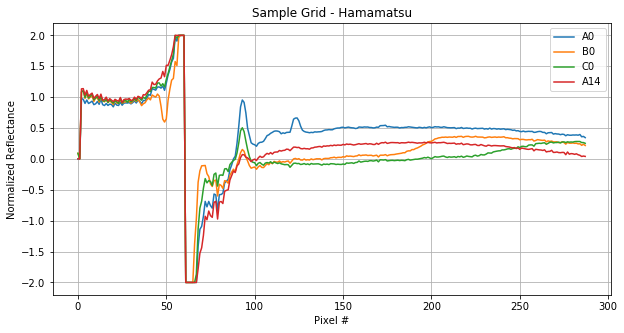

In [8]:
# Plot a sample of the Hamamatsu derived data
plt.plot(readings_cal['A0'][0,:-16], label='A0')
plt.plot(readings_cal['B0'][0,:-16], label='B0')
plt.plot(readings_cal['C0'][0,:-16], label='C0')
plt.plot(readings_cal['A14'][0,:-16], label='A14')
plt.grid()
plt.legend()
plt.title('Sample Grid - Hamamatsu')
plt.xlabel('Pixel #')
plt.ylabel('Normalized Reflectance')
plt.show()

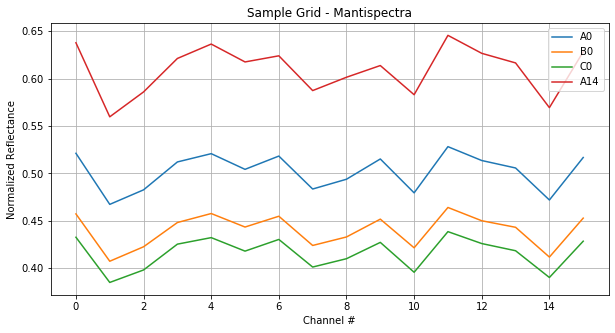

In [9]:
# Plot a sample of the Mantispectra derived data
plt.plot(readings_cal['A0'][0,-16:], label='A0')
plt.plot(readings_cal['B0'][0,-16:], label='B0')
plt.plot(readings_cal['C0'][0,-16:], label='C0')
plt.plot(readings_cal['A14'][0,-16:], label='A14')
plt.grid()
plt.legend()
plt.title('Sample Grid - Mantispectra')
plt.xlabel('Channel #')
plt.ylabel('Normalized Reflectance')
plt.show()

In [10]:
# Create all catgeory data with labels
all_data, labels = label_categories(data_by_contents)
all_data_cal, labels_cal = label_categories(data_by_contents_cal)

### Extract features from signals

In [11]:
# Calculate the 1st derivative of the data
def first_deriv(x, wavelengths):
    # First derivative of measurements with respect to wavelength
    x = np.copy(x)
    dx = np.zeros(x.shape, np.float)
    dx[0:-1] = np.diff(x)/np.diff(wavelengths)
    dx[-1] = (x[-1] - x[-2])/(wavelengths[-1] - wavelengths[-2])
    return dx

all_data_deriv = np.gradient(all_data_cal,2,axis=1)
# Calculate the fast fourier transform here
all_data_fft = np.fft.fft(all_data_cal, axis=1)
# Concatenated feature vectors
all_data_feature = np.hstack((all_data_deriv,all_data_fft))

/tmp/ipykernel_505698/3754332257.py:5: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  dx = np.zeros(x.shape, np.float)


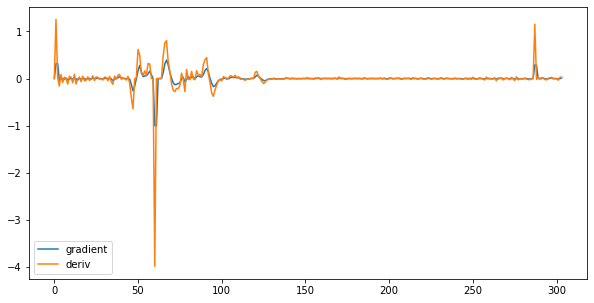

In [12]:
# plt.plot(np.gradient(all_data_cal[0,:]))
plt.plot(np.gradient(all_data_cal[0,:],2), label='gradient')
plt.plot(first_deriv(all_data_cal[0,:],np.linspace(0,304,304)), label='deriv')
# plt.plot(all_data_cal[1,:], label='signal')
plt.legend()
plt.show()

In [13]:
def build_network(architecture: str, input_size: int, classes: int, hidden_layers: Tuple=(256,128)) -> nn.Module:
    '''
    Generate a train able neural network architecture
    
    Args: 
        architecture (str): Type of architecture to generate
        input_size (int): Number of input features
        classes (int): Number of output features (classes)
        hidden_layers (Tuple, optional): Size of sequential hidden layers to use in network construction
        
    Returns:
        nn.Module: Model architecture
    '''
    D = input_size
    print(f'D: {D}')
    K = classes
    print(f'K: {K}')

    # find device to train on
    device = 'cuda' if torch.cuda.is_available() else 'cpu'
    print(f'Using {device} device')

    # use model that did well in cross val
    if architecture == 'mlp':
        num_perceptrons = hidden_layers
        num_hidden_layers = len(num_perceptrons)
        use_dropout = True
        model = MLP(D, K, num_hidden_layers, num_perceptrons, 
                    use_dropout).to(device).double()
    elif architecture == '1DCNN':
        use_dropout = True
        model = Simple1DCNN(D, K, use_dropout).to(device).double()
    else:
        raise NotImplementedError("Unsupported network architecture")
        
    return model, device

def train_val_test_split(all_data: np.ndarray, targets: np.ndarray) -> Tuple[DataLoader, DataLoader, DataLoader]:
    '''
    Create train-test-val split from model data
    
    Args: 
        all_data (np.ndarray): 2D matrix of data to analyze
        targets (list): Numerical categorical labels for each row of data
        
    Returns:
        Tuple[DataLoader,DataLoader,DataLoader]: Train dataloader; validation dataloader; test dataloader
    '''
    X_train, X_test, y_train, y_test = train_test_split(all_data.astype(np.double), targets, test_size=0.2)
    X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.25, random_state=1) # 0.25 x 0.8 = 0.2
    train_dataset = TensorDataset(torch.Tensor(X_train),torch.Tensor(y_train).type(torch.LongTensor)) # Main train set
    valid_dataset = TensorDataset(torch.Tensor(X_val),torch.Tensor(y_val).type(torch.LongTensor))  # Validation set
    test_dataset = TensorDataset(torch.Tensor(X_test),torch.Tensor(y_test).type(torch.LongTensor))  # Test set
    train_loader = DataLoader(dataset=train_dataset, batch_size=128, shuffle=True)
    val_loader = DataLoader(dataset=valid_dataset, batch_size=128, shuffle=False)
    test_loader = DataLoader(dataset=test_dataset, batch_size=128, shuffle=False)
    return train_loader, val_loader, test_loader

def train_val_test_split_cross(all_data: np.ndarray, targets: np.ndarray) -> Tuple[TensorDataset, TensorDataset, DataLoader]:
    '''
    Create train-test-val split from model data for cross validation model training
    
    Args: 
        all_data (np.ndarray): 2D matrix of data to analyze
        targets (list): Numerical categorical labels for each row of data
        
    Returns:
        Tuple[TensorDataset,TensorDataset,DataLoader]: Train dataset; validation dataset; test dataloader
    '''
    X_train, X_test, y_train, y_test = train_test_split(all_data.astype(np.double), targets, test_size=0.2)
    X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.25, random_state=1) # 0.25 x 0.8 = 0.2
    train_dataset = TensorDataset(torch.Tensor(X_train),torch.Tensor(y_train).type(torch.LongTensor)) # Main train set
    valid_dataset = TensorDataset(torch.Tensor(X_val),torch.Tensor(y_val).type(torch.LongTensor))  # Validation set
    test_dataset = TensorDataset(torch.Tensor(X_test),torch.Tensor(y_test).type(torch.LongTensor))  # Test set
    test_loader = DataLoader(dataset=test_dataset, batch_size=128, shuffle=False)
    return train_dataset, valid_dataset, test_loader

def reset_weights(m: nn.Module):
    '''
    Try resetting model weights to avoid weight leakage  
    
    Args:
        model (nn.Module): Network to reset weight on
        
    Returns:
        None
    '''
    for layer in m.children():
        if hasattr(layer, 'reset_parameters'):
            layer.reset_parameters()

def train_cross_val(model: nn.Module, architecture: str, train_dataset: TensorDataset, val_dataset: TensorDataset, epochs: int, device: str, save_prefix: str, trials=1, k_folds=5) -> Tuple[MLP, List, List, List]:
    '''
    Training routine for models with cross validation
    
    Args:
        model (nn.Module): Network to train
        architecture (str): Model type to run
        train_dataset (TensorDataset): Training data in tensor form
        val_dataset (TensorDataset): Validation data in tensor form
        epochs (int): Number of epochs to train each model for
        device (str): Location to execute computations over
        save_prefix (str): Prefix to use when saving model files
        trials (int, optional): Number of times to run and average model over
        k_folds (float, optional): Number of folds to use in splitting the model data
        
    Returns:
        nn.Module: Best trained model
    '''
    # Define the K-fold Cross Validator
    kfold = KFold(n_splits=k_folds, shuffle=True)
    models = []
    train_loss_all = []
    val_loss_all = []
    val_accuracy_all = []
    models = []
    for trial in tqdm(range(trials), desc='Trial:', position=0):
        train_loss = []
        val_loss = []
        val_accuracy = []
        loss_fn = nn.CrossEntropyLoss()
        optimizer = torch.optim.SGD(model.parameters(), lr=0.01, momentum=0.9)
        best_acc = 0
        dataset = ConcatDataset([train_dataset, val_dataset])
        results = defaultdict(lambda: 0)
        reset_weights(model)
        # K-fold Cross Validation model evaluation
        for fold, (train_ids, test_ids) in tqdm(enumerate(kfold.split(dataset)), desc='Fold:', position=1, leave=False):
            best_acc = 0.00
            temp_models = []
            # Sample elements randomly from a given list of ids, no replacement.
            train_subsampler = torch.utils.data.SubsetRandomSampler(train_ids)
            test_subsampler = torch.utils.data.SubsetRandomSampler(test_ids)

            # Define data loaders for training and testing data in this fold
            train_loader = torch.utils.data.DataLoader(
                              dataset, 
                              batch_size=128, sampler=train_subsampler)
            test_loader = torch.utils.data.DataLoader(
                              dataset,
                              batch_size=128, sampler=test_subsampler)
            # Train model for number of epochs
            for epoch in tqdm(range(epochs), desc='Epoch', position=2, leave=False):
                model.train()
                running_loss = 0
                last_loss = 0
                total_correct = 0
                running_loss_train = 0
                for i, data in enumerate(train_loader):
                    inputs, true_labels = data[0].to(device), data[1].to(device)
                    optimizer.zero_grad()

                    outputs = model(inputs.double())
                    loss = loss_fn(outputs, true_labels)
                    loss.backward()
                    optimizer.step()

                    running_loss_train += loss.item()

                    # calculate accuracy
                    pred_labels = torch.argmax(outputs, dim=1, keepdim=False)
                    # true_labels = torch.argmax(true_labels, dim=1, keepdim=False)
                    correct = (pred_labels == true_labels).float().sum()
                    total_correct += correct

                    if i % 10 == 9:
                        last_loss = running_loss_train / 10

            model.train(False)
            running_loss_val = 0.0
            correct = 0
            cum_samples = 0
            for i, val_data in enumerate(test_loader):
                inputs, true_labels = val_data[0].to(device), val_data[1].to(device)
                cum_samples += len(true_labels) 
                # calculate loss
                output = model(inputs.double())
                loss = loss_fn(output, true_labels)
                running_loss_val += loss.item()

                # calculate accuracy
                pred_labels = torch.argmax(output, dim=1, keepdim=False)
                # true_labels = torch.argmax(true_labels, dim=1, keepdim=False)
                correct += (pred_labels == true_labels).float().sum()

            avg_val_loss = running_loss_val / (i + 1)

            results[fold] = correct.cpu()/cum_samples
            if results[fold] > best_acc:
                best_model = [results[fold],deepcopy(model)]

        print(f'TRIAL: {trial} K-FOLD CROSS VALIDATION RESULTS FOR {k_folds} FOLDS')
        print('--------------------------------')
        run_sum = 0.0
        for key, value in results.items():
            # print(f'Fold {key}: {value} %')
            run_sum += value
        print(f'Average: {run_sum/len(results.items())} %')
        models.append(best_model)
    # Find and return the best model
    return sorted(models, key=lambda a: a[0], reverse=True)[0][1]
        
def train_model(model: nn.Module, architecture: str, train_loader: DataLoader, val_loader: DataLoader, epochs: int, device: str, save_prefix: str, trials=1, mean=0, sigma=0.05) -> Tuple[nn.Module, List, List, List]:
    '''
    Training routine for models
    
    Args:
        model (nn.Module): Network to train
        architecture (str): Model type to run
        train_loader (DataLoader): Object to load training data and labels
        val_loader (DataLoader): Object to load validation data and labels
        epochs (int): Number of epochs to train each model for
        device (str): Location to execute computations over
        save_prefix (str): Prefix to use when saving model files
        trials (int, optional): Number of times to run and average model over
        mean (float, optional): Mean to use for injecting gaussian noise into training
        sigma (float, optional): Variance to use for injecting gaussian noise into training
        
    Returns:
        Tuple[nn.Module, List, List, List]: Best modle trained; training loss; validation loss; validation accuracy
    '''
    models = []
    train_loss_all = []
    val_loss_all = []
    val_accuracy_all = []
    for trial in tqdm(range(trials), desc='Trial:', position=0):
        reset_weights(model)
        train_loss = []
        val_loss = []
        val_accuracy = []
        loss_fn = nn.CrossEntropyLoss()
        optimizer = torch.optim.SGD(model.parameters(), lr=0.01, momentum=0.9)
        best_acc = 0
        for epoch in tqdm(range(epochs), desc='Epoch', position=1 ,leave=False):
            model.train()
            running_loss = 0
            last_loss = 0
            total_correct = 0
            running_loss_train = 0
            for i, data in enumerate(train_loader):
                inputs, true_labels = data[0], data[1].to(device)
                inputs = inputs + torch.randn(*inputs.shape)*sigma+mean
                inputs = inputs.to(device)
                optimizer.zero_grad()

                outputs = model(inputs.double())
                loss = loss_fn(outputs, true_labels)
                loss.backward()
                optimizer.step()

                running_loss_train += loss.item()

                # calculate accuracy
                pred_labels = torch.argmax(outputs, dim=1, keepdim=False)
                # true_labels = torch.argmax(true_labels, dim=1, keepdim=False)
                correct = (pred_labels == true_labels).float().sum()
                total_correct += correct

                if i % 10 == 9:
                    last_loss = running_loss_train / 10

            # Keep track of train loss
            train_loss.append(last_loss)

            model.train(False)
            running_loss_val = 0.0
            correct = 0
            cum_samples = 0
            for i, val_data in enumerate(val_loader):
                inputs, true_labels = val_data[0].to(device), val_data[1].to(device)
                cum_samples += len(true_labels) 
                # calculate loss
                output = model(inputs.double())
                loss = loss_fn(output, true_labels)
                running_loss_val += loss.item()

                # calculate accuracy
                pred_labels = torch.argmax(output, dim=1, keepdim=False)
                # true_labels = torch.argmax(true_labels, dim=1, keepdim=False)
                correct += (pred_labels == true_labels).float().sum()

            avg_val_loss = running_loss_val / (i + 1)
            val_loss.append(avg_val_loss)
            if correct.cpu()/cum_samples > best_acc:
                best_acc = correct.cpu()/cum_samples
                torch.save(model.state_dict(), f'./weights/{save_prefix}__{architecture}_best.wts')

            val_accuracy.append(correct.cpu()/cum_samples)
    # Copy over the model
    models.append(model)
    train_loss_all.append(deepcopy(train_loss))
    val_loss_all.append(deepcopy(val_loss))
    val_accuracy_all.append(deepcopy(val_accuracy))
        
    return model, np.mean(train_loss_all,axis=0), np.mean(val_loss_all,axis=0), np.mean(val_accuracy_all,axis=0)

def test_accuracy(model: nn.Module, test_loader: DataLoader, device: str, le: preprocessing.LabelEncoder, prefix: str) -> None:
    '''
    Calculate test accuracy using held-out dataset
    Args: 
        model (nn.Module): Model architecture to pass data through
        test_loader (DataLoader): PyTorch dataloader with references to test data
        device (str): Location to execute computations over
        le (preproccessing.LabelEncoder): Object used to translate string labels into numeric indicies
        prefix (str): Prefix to use when saving model files
        
    Returns:
        None
    '''
    # Evaluate model on held out test set
    model.train(False)
    test_accuracy = []
    running_loss_val = 0.0
    correct = 0
    cum_samples = 0
    all_true = []
    all_preds = []
    for i, val_data in enumerate(test_loader):
        inputs, true_labels = val_data[0].to(device), val_data[1].to(device)
        all_true.extend(list(true_labels.cpu()))
        cum_samples += len(true_labels) 
        # calculate loss
        output = model(inputs.double())

        # calculate accuracy
        pred_labels = torch.argmax(output, dim=1, keepdim=False)
        all_preds.extend(list(pred_labels.cpu()))
        # true_labels = torch.argmax(true_labels, dim=1, keepdim=False)
        correct += (pred_labels == true_labels).float().sum()

    print(f'Heldout Test Accuracy: {correct.cpu()/cum_samples}')
    disp = ConfusionMatrixDisplay.from_predictions(le.inverse_transform(all_true), le.inverse_transform(all_preds), normalize='true')
    plt.xticks(rotation = 90) # Rotates X-Axis Ticks by 45-degrees
    fig = disp.ax_.get_figure() 
    fig.set_figwidth(12)
    fig.set_figheight(12)
    plt.title('Full Data Confusion Matrix')
    plt.savefig(f"./figs/{prefix}_confusion_matrix.png")
    plt.show()
    

def plot_confusion_results(model: nn.Module, all_data: np.ndarray, targets: np.ndarray, le: preprocessing.LabelEncoder, device: str, prefix: str, descriptor: str) -> None:
    '''
    Generate predictions from neural network module and create confusion matrix
    Args: 
        model (nn.Module): Model architecture to pass data through
        all_data (np.ndarray): 2D matrix of data to analyze
        targets (np.ndarray): Numerical categorical labels for each row of data
        le (preproccessing.LabelEncoder): Object used to translate string labels into numeric indicies
        device (str): Location to execute computations over
        prefix (str): Prefix to use when saving model files
        descriptor (str): Title descriptor for displaying with figures
        
    Returns:
        None
    '''
    with torch.no_grad():
        pred_labels = torch.argmax(model(torch.Tensor(all_data).to(device).double()), dim=1, keepdim=False).cpu()
    
    disp = ConfusionMatrixDisplay.from_predictions(le.inverse_transform(targets), le.inverse_transform(pred_labels), normalize='true')
    plt.xticks(rotation = 90) # Rotates X-Axis Ticks by 45-degrees
    fig = disp.ax_.get_figure() 
    fig.set_figwidth(12)
    fig.set_figheight(12)
    plt.title('Full Data Confusion Matrix')
    plt.savefig(f"./figs/{prefix}_confusion_matrix.png")
    plt.show()
    
def plot_train_results(train_loss: List, val_loss: List, val_accuracy: List, prefix: str, descriptor: str) -> None:
    '''
    Plots loss and accuracy results from training a model
    
    Args: 
        train_loss (list): Numerical data for training loss as a function of epoch
        val_loss (list): Numerical data for validation loss as a function of epoch
        val_accuracy (list): Numerical data for validation accuracy over training
        prefix (str): Prefix to use when saving model files
        descriptor (str): Title descriptor for displaying with figures
        
    Returns:
        None
    '''
    # View training results
    plt.figure(1)
    plt.plot(range(1, len(train_loss) + 1), train_loss, label="Train loss")
    plt.plot(range(1, len(train_loss) + 1), val_loss, label="Val loss")
    plt.legend()
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.grid()
    plt.title(f"{descriptor} - Train & Validation Loss")
    plt.savefig(f"./figs/{prefix}_train_val_loss.png")
    plt.show()
    # Accuracy
    plt.figure(2)
    plt.plot(range(1, len(val_accuracy) + 1), np.array(val_accuracy) * 100, label="Val accuracy")
    plt.legend()
    plt.xlabel("Epoch")
    plt.ylabel("Accuracy %")
    plt.title(f"{descriptor} - Spectral Validation Accuracy")
    plt.grid()
    plt.savefig(f"./figs/{prefix}_spectral_val_acc.png")
    plt.show()
    
def model_master_cross_val(architecture: str, all_data: np.ndarray, labels: list, epochs: int, prefix: str, descriptor: str, trials=10, k_folds=5):
    '''
    Main function used to train spectroscopy models
    
    Args: 
        architecture (str): Model type to run
        all_data (np.ndarray): 2D matrix of data to analyze
        labels (list): Numerical categorical labels for each row of data
        epochs (int): Number of epochs to train each model for
        prefix (str): Prefix to use when saving model files
        descriptor (str): Title descriptor for displaying with figures
        trials (int, optional): Number of times to run and average model over
        k_folds (int, optional): Number of folds to use when splitting model data
        
    Returns:
        None
    '''
    # Create model architecture
    model, device = build_network(architecture, all_data.shape[1],len(np.unique(labels)))
    # Fit labels to model
    le = preprocessing.LabelEncoder()
    targets = le.fit_transform(labels)
    # Create data splits
    train_loader, val_loader, test_loader = train_val_test_split_cross(all_data,targets)
    # Train model given parameters
    model = train_cross_val(model, architecture, train_loader, val_loader, epochs, device, prefix, trials=trials, k_folds=k_folds)
    torch.save(model.state_dict(), f'./weights/{prefix}__{architecture}_cross_val_best.wts')
    model.to(device)
    # Calculate model statistics
    test_accuracy(model, test_loader, device, le, prefix)

def model_master(architecture: str, all_data: np.ndarray, labels: list, epochs: int, prefix: str, descriptor: str, trials=10, sigma=0.1, hidden_layers=(256,128)):
    '''
    Main function used to train spectroscopy models
    
    Args: 
        architecture (str): Model type to run
        all_data (np.ndarray): 2D matrix of data to analyze
        labels (list): Numerical categorical labels for each row of data
        epochs (int): Number of epochs to train each model for
        prefix (str): Prefix to use when saving model files
        descriptor (str): Title descriptor for displaying with figures
        trials (int, optional): Number of times to run and average model over
        sigma (float, optional): Sigma for Gaussian noise process to inject while training
        hidden_layers (Tuple, optional): Size of sequential hidden layers to use in network construction
        
    Returns:
        None
    '''
    # Create model architecture
    model, device = build_network(architecture, all_data.shape[1],len(np.unique(labels)),hidden_layers=hidden_layers)
    # Fit labels to model
    le = preprocessing.LabelEncoder()
    targets = le.fit_transform(labels)
    # Create data splits
    train_loader, val_loader, test_loader = train_val_test_split(all_data,targets)
    # Train model given parameters
    model, train_loss, val_loss, val_accuracy = train_model(model, architecture, train_loader, val_loader, epochs, device, prefix, trials=trials, sigma=sigma)
    model.load_state_dict(torch.load(f'./weights/{prefix}__{architecture}_best.wts'))
    model.to(device)
    # Plot training results
    plot_train_results(train_loss, val_loss, val_accuracy, prefix, descriptor)
    # Calculate model statistics
    test_accuracy(model, test_loader, device, le, prefix)

### Part 1a: Train MLP on all available data

#### Train stock MLP with added Gaussian noise (Most Robust)

D: 304
K: 18
Using cuda device


Trial::   0%|          | 0/10 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

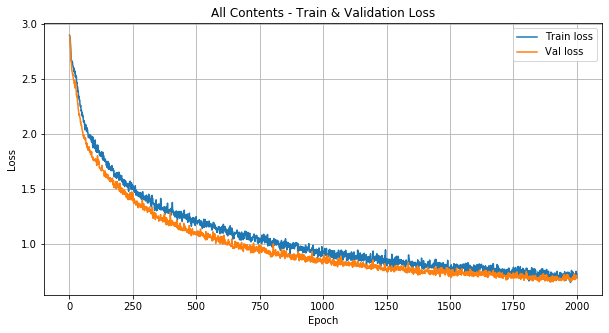

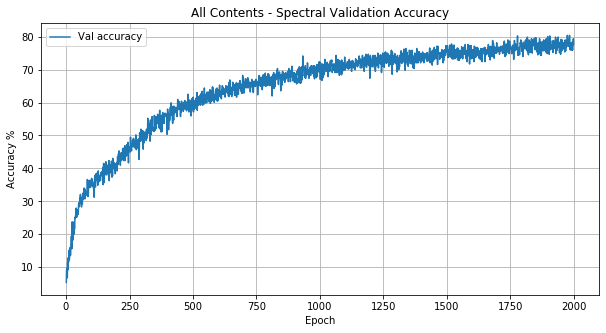

Heldout Test Accuracy: 0.7708333134651184


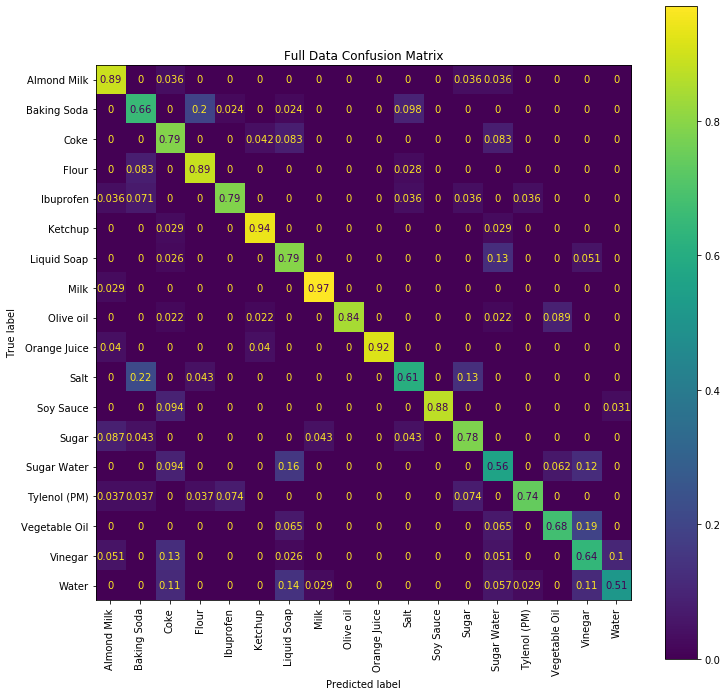

In [14]:
model_master('mlp',all_data_cal,labels_cal,2000,'all_contents','All Contents', trials=10, sigma=0.025)

#### Train MLP with cross validation

D: 304
K: 18
Using cuda device


Trial::   0%|          | 0/10 [00:00<?, ?it/s]

Fold:: 0it [00:00, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

TRIAL: 0 K-FOLD CROSS VALIDATION RESULTS FOR 5 FOLDS
--------------------------------
Average: 0.8849995732307434 %


Fold:: 0it [00:00, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

TRIAL: 1 K-FOLD CROSS VALIDATION RESULTS FOR 5 FOLDS
--------------------------------
Average: 0.8585268259048462 %


Fold:: 0it [00:00, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

TRIAL: 2 K-FOLD CROSS VALIDATION RESULTS FOR 5 FOLDS
--------------------------------
Average: 0.8611327409744263 %


Fold:: 0it [00:00, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

TRIAL: 3 K-FOLD CROSS VALIDATION RESULTS FOR 5 FOLDS
--------------------------------
Average: 0.847248911857605 %


Fold:: 0it [00:00, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

TRIAL: 4 K-FOLD CROSS VALIDATION RESULTS FOR 5 FOLDS
--------------------------------
Average: 0.8073139190673828 %


Fold:: 0it [00:00, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

TRIAL: 5 K-FOLD CROSS VALIDATION RESULTS FOR 5 FOLDS
--------------------------------
Average: 0.8181598782539368 %


Fold:: 0it [00:00, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

TRIAL: 6 K-FOLD CROSS VALIDATION RESULTS FOR 5 FOLDS
--------------------------------
Average: 0.7847439646720886 %


Fold:: 0it [00:00, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

TRIAL: 7 K-FOLD CROSS VALIDATION RESULTS FOR 5 FOLDS
--------------------------------
Average: 0.7960444688796997 %


Fold:: 0it [00:00, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

TRIAL: 8 K-FOLD CROSS VALIDATION RESULTS FOR 5 FOLDS
--------------------------------
Average: 0.7764924764633179 %


Fold:: 0it [00:00, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

TRIAL: 9 K-FOLD CROSS VALIDATION RESULTS FOR 5 FOLDS
--------------------------------
Average: 0.7938488721847534 %
Heldout Test Accuracy: 0.8888888955116272


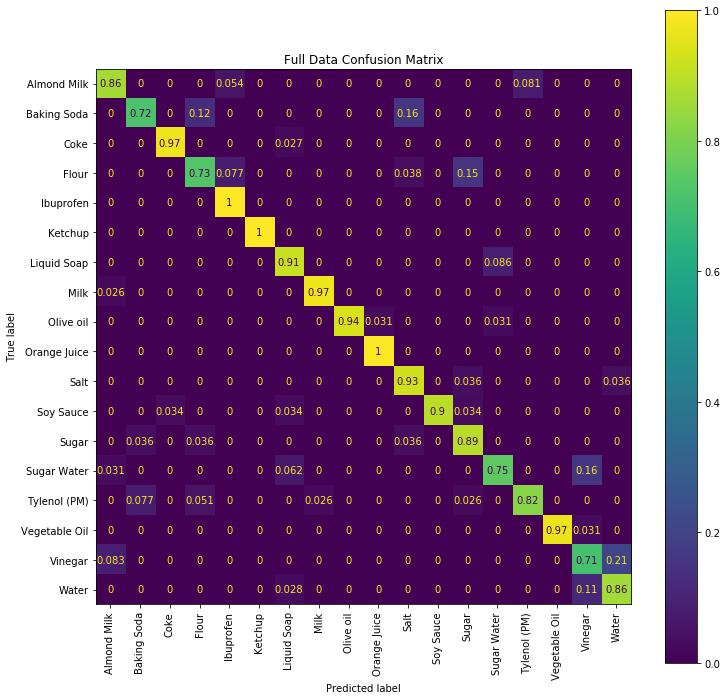

In [15]:
model_master_cross_val('mlp',all_data_cal,labels_cal,2000,'all_contents','All Contents', trials=10, k_folds=5)

#### Train MLP using extracted features

D: 304
K: 18
Using cuda device


Trial::   0%|          | 0/1 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

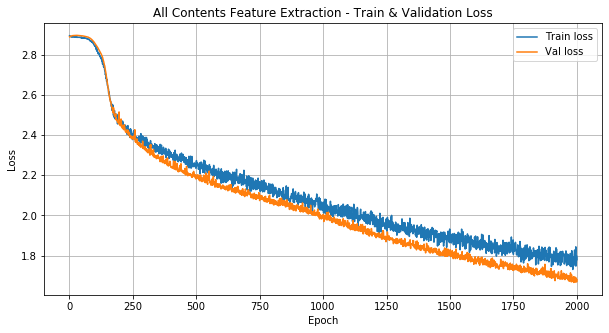

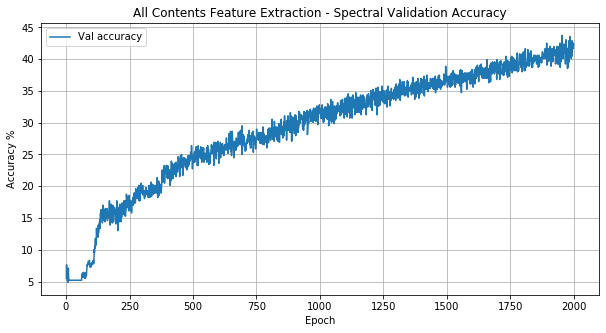

Heldout Test Accuracy: 0.4444444477558136


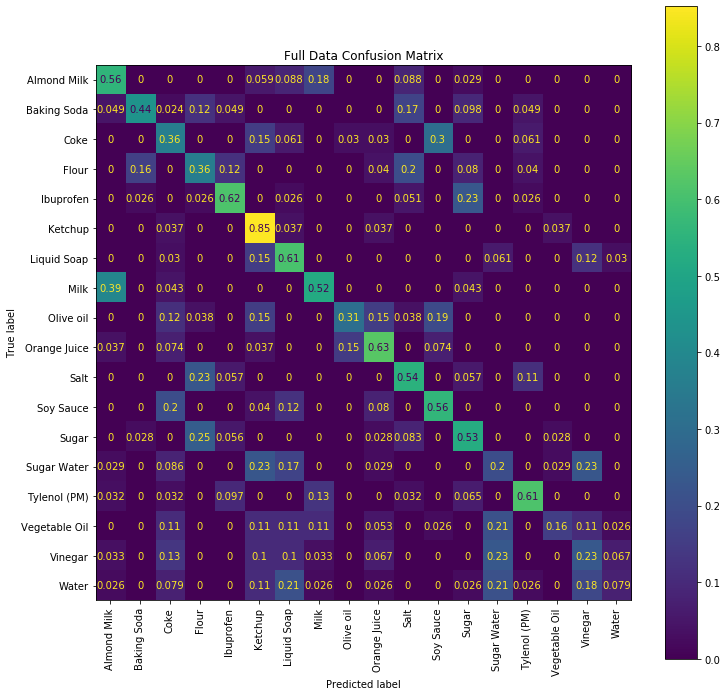

In [16]:
model_master('mlp',all_data_deriv,labels_cal,2000,'all_contents_feature','All Contents Feature Extraction', sigma=0.025, trials=1)

#### Train 1-D CNN with stock data

D: 304
K: 18
Using cuda device


Trial::   0%|          | 0/1 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

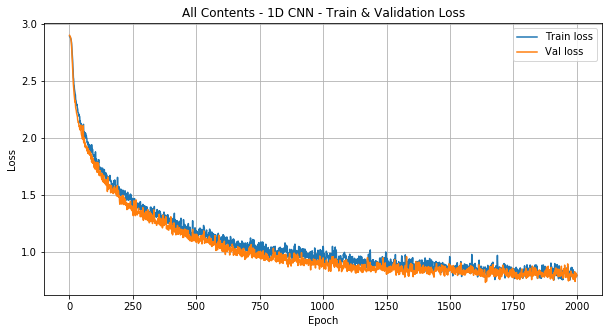

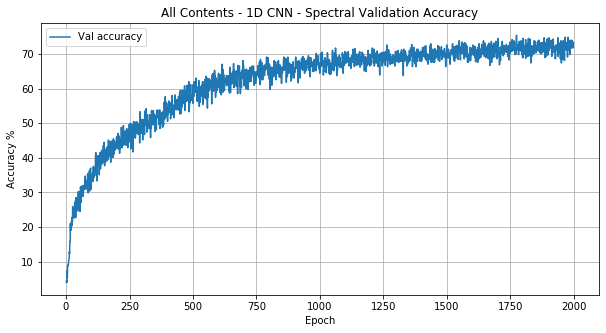

Heldout Test Accuracy: 0.7586805820465088


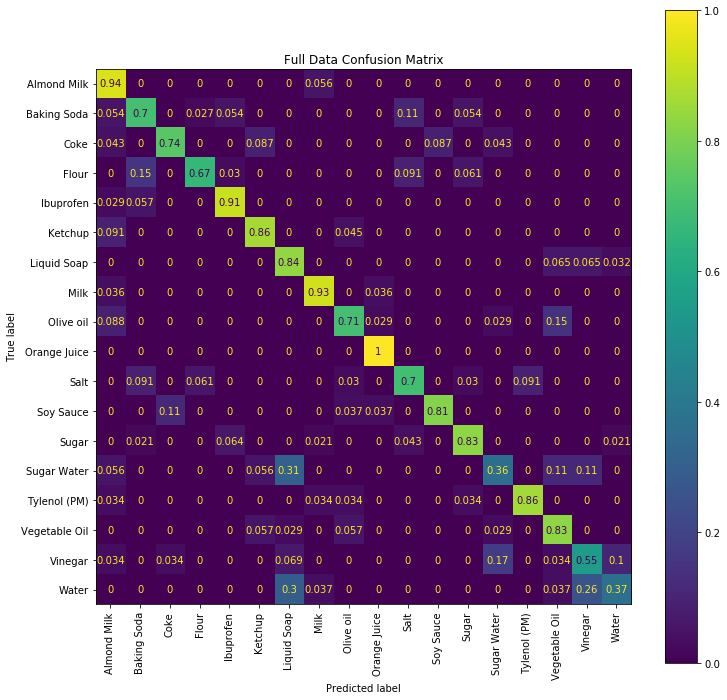

In [17]:
model_master('1DCNN',all_data_cal,labels_cal,2000,'all_contents','All Contents - 1D CNN',sigma=0.025, trials=1)

#### Train 1-D CNN with extracted features

D: 304
K: 18
Using cuda device


Trial::   0%|          | 0/1 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

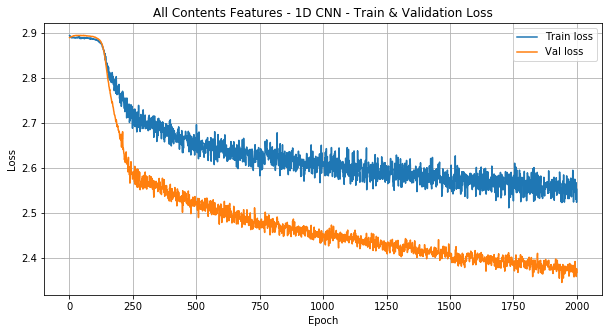

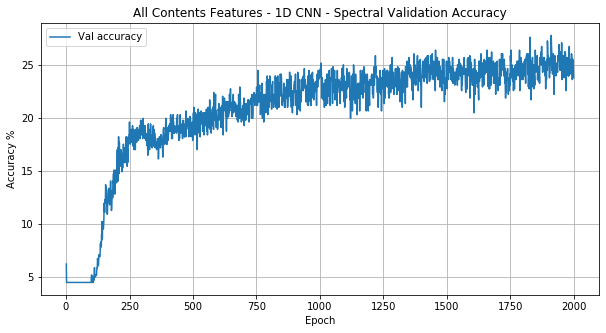

Heldout Test Accuracy: 0.2690972089767456


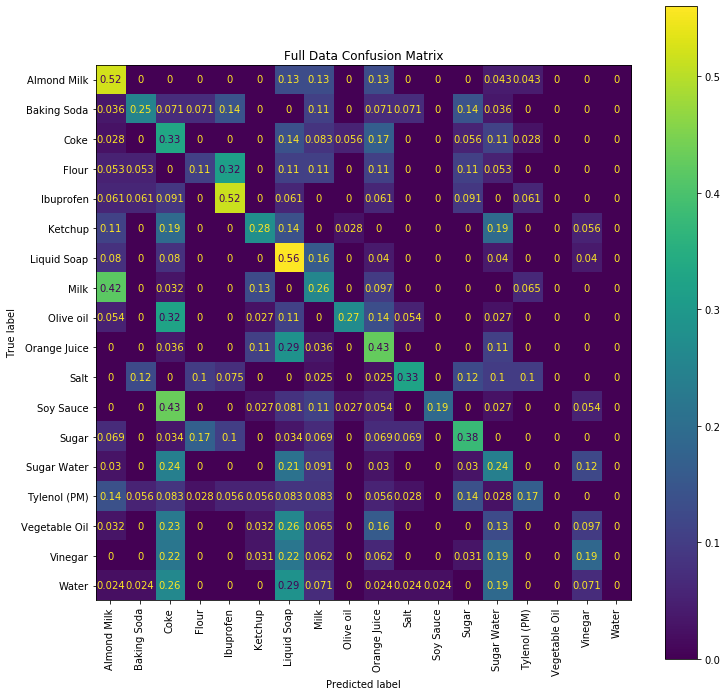

In [18]:
model_master('1DCNN',all_data_deriv,labels_cal,2000,'all_contents_features','All Contents Features - 1D CNN', trials=1)

### Part 1b: Train only on Hamamatsu Data

D: 288
K: 18
Using cuda device


Trial::   0%|          | 0/10 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

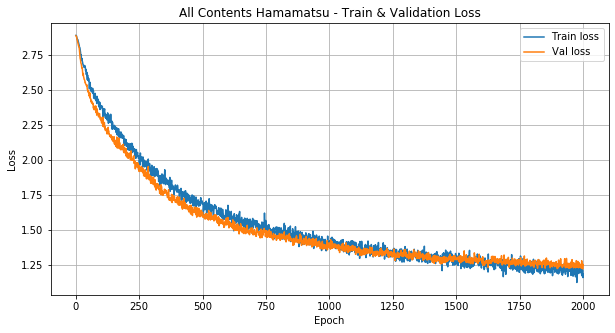

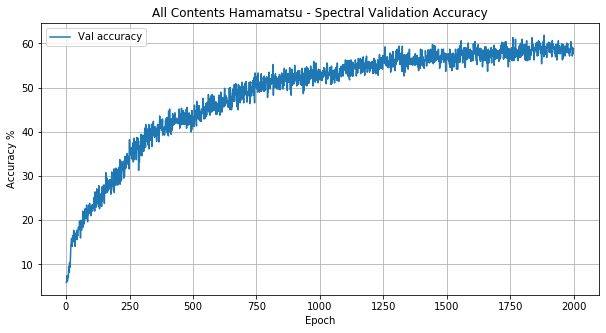

Heldout Test Accuracy: 0.6753472089767456


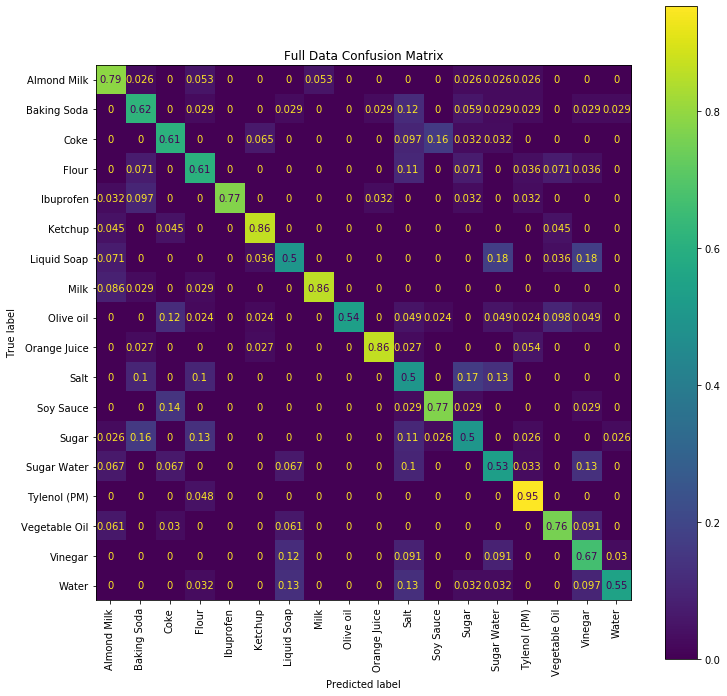

In [19]:
model_master('mlp',all_data_cal[:,:-16],labels_cal,2000,'all_contents_hamamatsu','All Contents Hamamatsu', trials=10)

D: 288
K: 18
Using cuda device


Trial::   0%|          | 0/1 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

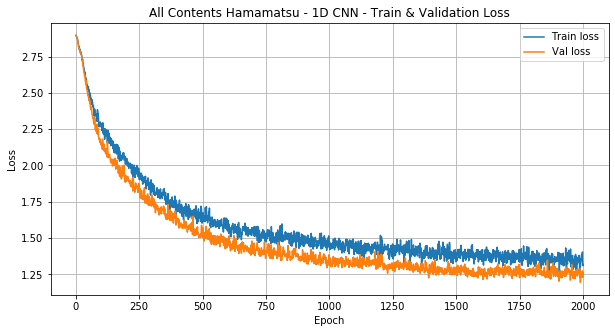

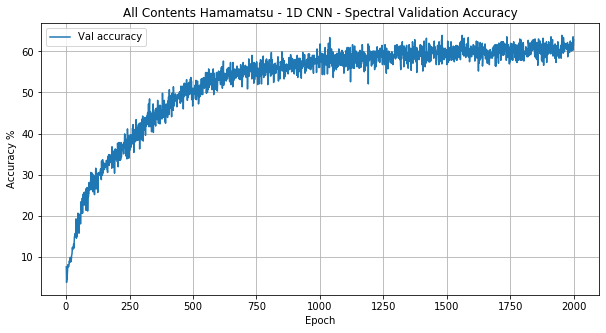

Heldout Test Accuracy: 0.6354166865348816


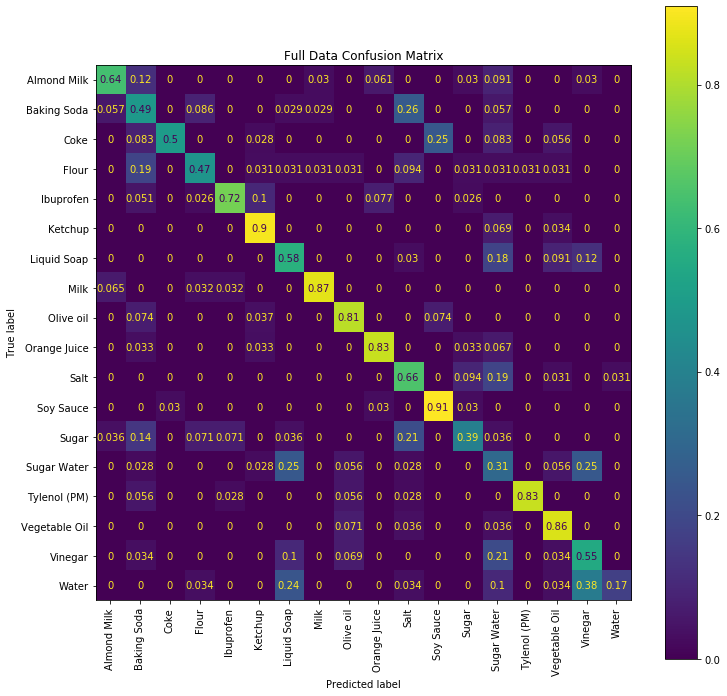

In [20]:
model_master('1DCNN',all_data_cal[:,:-16],labels_cal,2000,'all_contents','All Contents Hamamatsu - 1D CNN', trials=1)

### Part 1c: Train only on Mantispectra Data

D: 16
K: 18
Using cuda device


Trial::   0%|          | 0/10 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

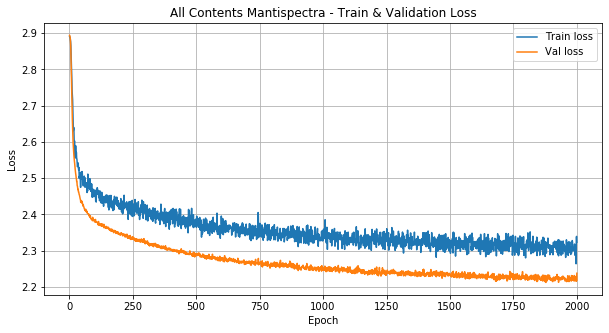

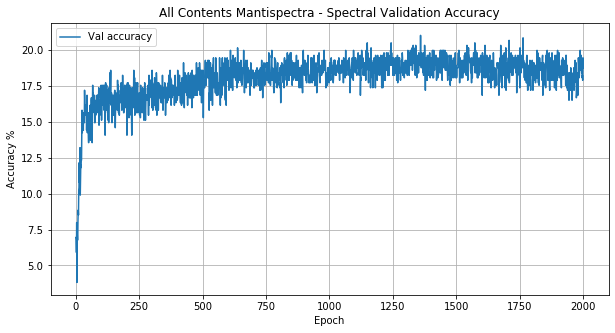

Heldout Test Accuracy: 0.1996527761220932


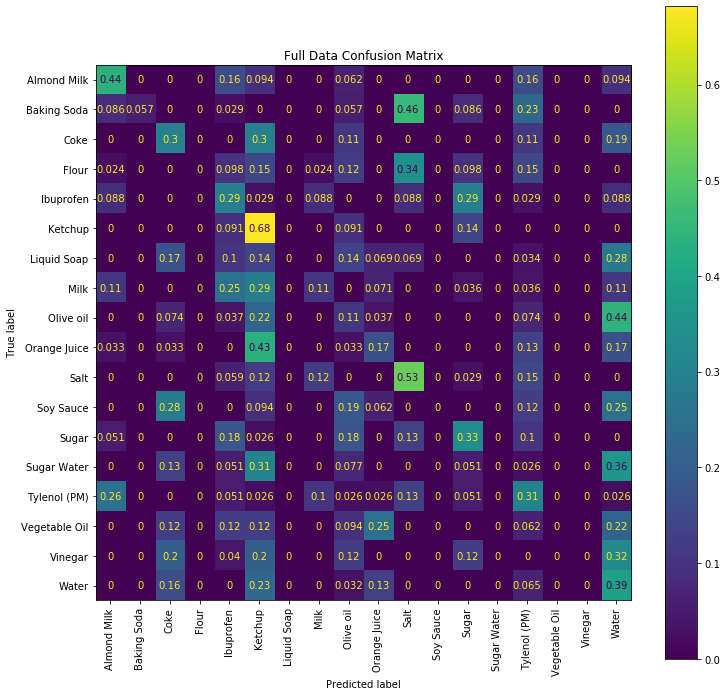

In [21]:
model_master('mlp',all_data_cal[:,-16:],labels_cal,2000,'all_contents_mantispectra','All Contents Mantispectra', trials=10)

D: 16
K: 18
Using cuda device


Trial::   0%|          | 0/1 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

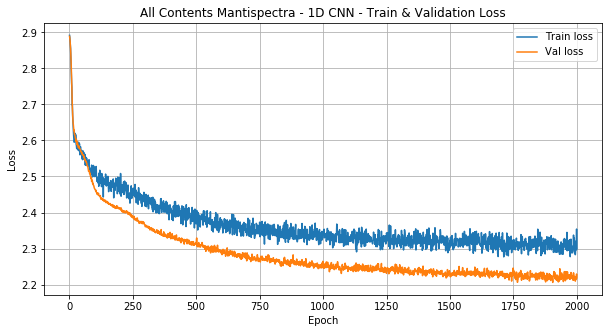

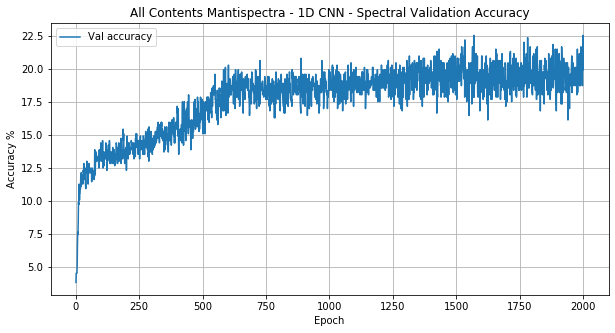

Heldout Test Accuracy: 0.234375


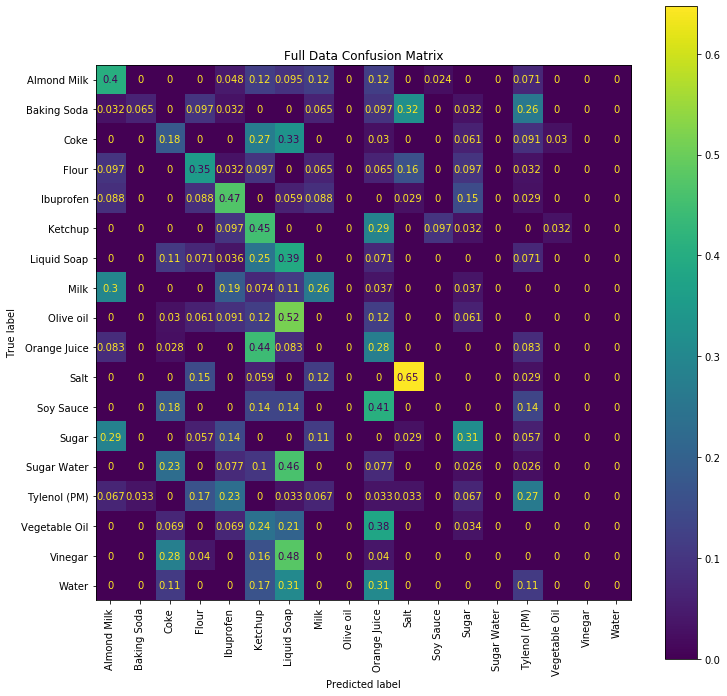

In [22]:
model_master('1DCNN',all_data_cal[:,-16:],labels_cal,2000,'all_contents','All Contents Mantispectra - 1D CNN', trials=1)

### Part 1d: Train Fusion Network

D: 288
K: 18
Using cuda device
D: 16
K: 18
Using cuda device
D: 36
K: 18
Using cuda device


Trial::   0%|          | 0/10 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

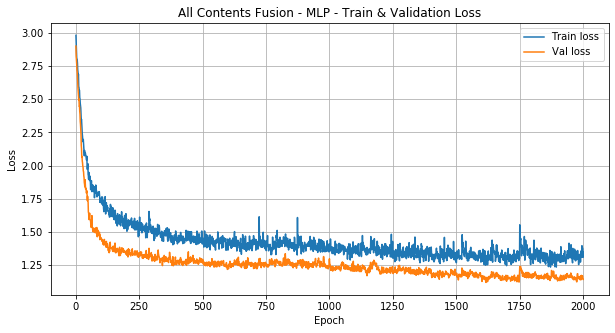

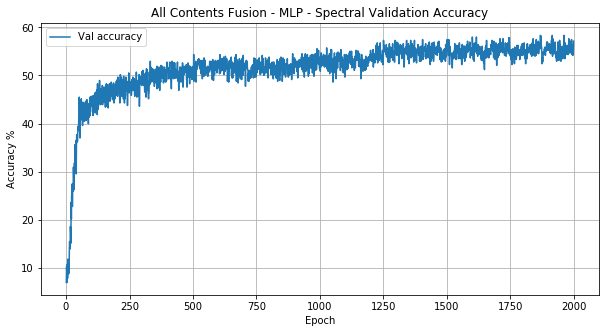

Heldout Test Accuracy: 0.5798611044883728


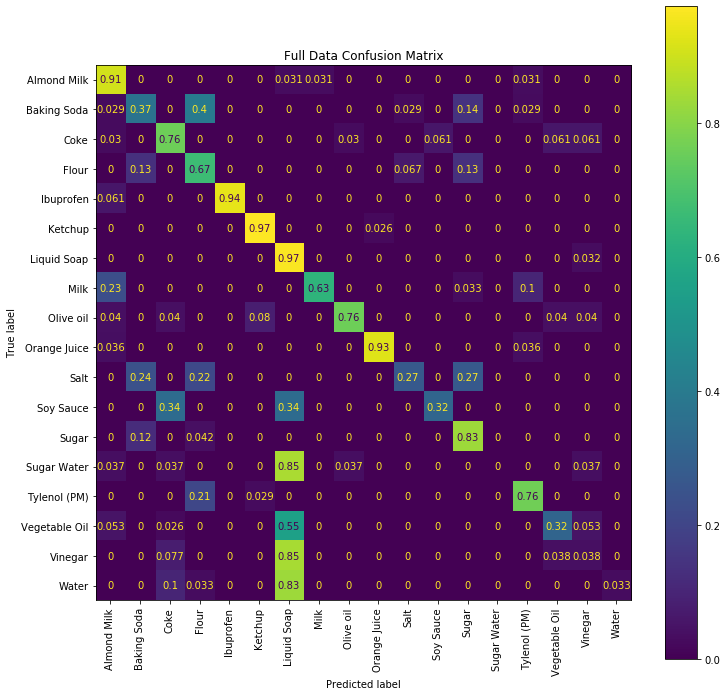

In [23]:
def normalized(a, axis=-1, order=2):
    l2 = np.atleast_1d(np.linalg.norm(a, order, axis))
    l2[l2==0] = 1
    return a / np.expand_dims(l2, axis)

from sklearn.preprocessing import normalize, StandardScaler

model_hama, device = build_network('mlp', 288, 18)
model_hama.load_state_dict(torch.load(f'./weights/all_contents_hamamatsu__mlp_best.wts', map_location='cpu'))
model_manti, device = build_network('mlp', 16, 18)
model_manti.load_state_dict(torch.load(f'./weights/all_contents_mantispectra__mlp_best.wts', map_location='cpu'))

# Pass all data through model to generate fusion weights
model_hama.eval()
model_manti.eval()
scaler_hama = preprocessing.StandardScaler()
scaler_manti = preprocessing.StandardScaler()
with torch.no_grad():
    pred_hama = model_hama(torch.Tensor(all_data_cal[:,:-16]).double().to(device)).cpu().numpy()
    pred_manti = model_manti(torch.Tensor(all_data_cal[:,-16:]).double().to(device)).cpu().numpy()
    fusion_data = np.hstack((pred_hama,pred_manti))
    
model_master('mlp',fusion_data,labels_cal,2000,'all_contents_fusion','All Contents Fusion - MLP', trials=10, hidden_layers=(30,20,18))

## Part 2: Modeling Across Containers

In [24]:
# Generalized function to group data by the contents type
def sort_by_container(readings: Dict) -> defaultdict:
    data_by_container = defaultdict(lambda: np.array([]))
    # Iterate over all data_frames types
    for key in readings.keys():
        # Iterate over all containers, but skip Aluminum (P), Stainless Steel (Q), and Wood (R)
        if 'P' in key or 'Q' in key or 'R' in key:
            continue
        for index, val in enumerate(containers):
            if key not in list(pairings[val]):
                continue
            # Otherwise the data is useful to use, let's proceed with the data wrangling
            useData = readings[key]
            # Add the index as the key value
            data_by_contents[val] = np.vstack((data_by_contents[val], useData)) if data_by_contents[val].size else useData
    return data_by_contents

# Create labels from category data
def label_categories(data_by_contents: defaultdict) -> Tuple[np.ndarray, List]:
    # Create all catgeory data with labels
    all_data = []
    labels = []
    for key in data_by_contents.keys():
        n_samples = data_by_contents[key].shape[0]
        labels.append([key]*n_samples)
        all_data = np.vstack((all_data,data_by_contents[key])) if len(all_data) > 0 else data_by_contents[key]
    labels = np.array([item for sublist in labels for item in sublist])
    return all_data, labels

In [25]:
# Generate list of all possible containers
containers = list(set(pairings['container / substrate']))

#### Associate material readings across containers

In [26]:
data_by_container = defaultdict(lambda: np.array([]))
# Iterate over all data_frames types
for key in readings_cal.keys():
    # Iterate over all containers, but skip Aluminum (P), Stainless Steel (Q), and Wood (R)
    if 'P' in key or 'Q' in key or 'R' in key:
        continue
    # print(key)
    # Every container will have an associated reading
    use_container = (pairings.iloc[list(pairings[pairings.columns[0]]).index(key[0])]['container / substrate'])
    useData = readings_cal[key]
    # Add the index as the key value
    data_by_container[use_container] = np.vstack((data_by_container[use_container], useData)) if data_by_container[use_container].size else useData

In [27]:
# Create all catgeory data with labels
all_data_container = []
labels_container = []
for key in data_by_container.keys():
    n_samples = data_by_container[key].shape[0]
    labels_container.append([key]*n_samples)
    all_data_container = np.vstack((all_data_container, data_by_container[key])) if len(all_data_container) > 0 else data_by_container[key]
labels_container = np.array([item for sublist in labels_container for item in sublist])

### Part 2a: Train MLP on all available container data

D: 304
K: 9
Using cuda device


Trial::   0%|          | 0/10 [00:00<?, ?it/s]

Fold:: 0it [00:00, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

TRIAL: 0 K-FOLD CROSS VALIDATION RESULTS FOR 5 FOLDS
--------------------------------
Average: 0.9778107404708862 %


Fold:: 0it [00:00, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

TRIAL: 1 K-FOLD CROSS VALIDATION RESULTS FOR 5 FOLDS
--------------------------------
Average: 0.9712196588516235 %


Fold:: 0it [00:00, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

TRIAL: 2 K-FOLD CROSS VALIDATION RESULTS FOR 5 FOLDS
--------------------------------
Average: 0.9790351986885071 %


Fold:: 0it [00:00, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

TRIAL: 3 K-FOLD CROSS VALIDATION RESULTS FOR 5 FOLDS
--------------------------------
Average: 0.9609602689743042 %


Fold:: 0it [00:00, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

TRIAL: 4 K-FOLD CROSS VALIDATION RESULTS FOR 5 FOLDS
--------------------------------
Average: 0.9506815075874329 %


Fold:: 0it [00:00, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

TRIAL: 5 K-FOLD CROSS VALIDATION RESULTS FOR 5 FOLDS
--------------------------------
Average: 0.9395855665206909 %


Fold:: 0it [00:00, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

TRIAL: 6 K-FOLD CROSS VALIDATION RESULTS FOR 5 FOLDS
--------------------------------
Average: 0.926424503326416 %


Fold:: 0it [00:00, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

TRIAL: 7 K-FOLD CROSS VALIDATION RESULTS FOR 5 FOLDS
--------------------------------
Average: 0.894741415977478 %


Fold:: 0it [00:00, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

TRIAL: 8 K-FOLD CROSS VALIDATION RESULTS FOR 5 FOLDS
--------------------------------
Average: 0.9350428581237793 %


Fold:: 0it [00:00, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

TRIAL: 9 K-FOLD CROSS VALIDATION RESULTS FOR 5 FOLDS
--------------------------------
Average: 0.9062818288803101 %
Heldout Test Accuracy: 0.9786184430122375


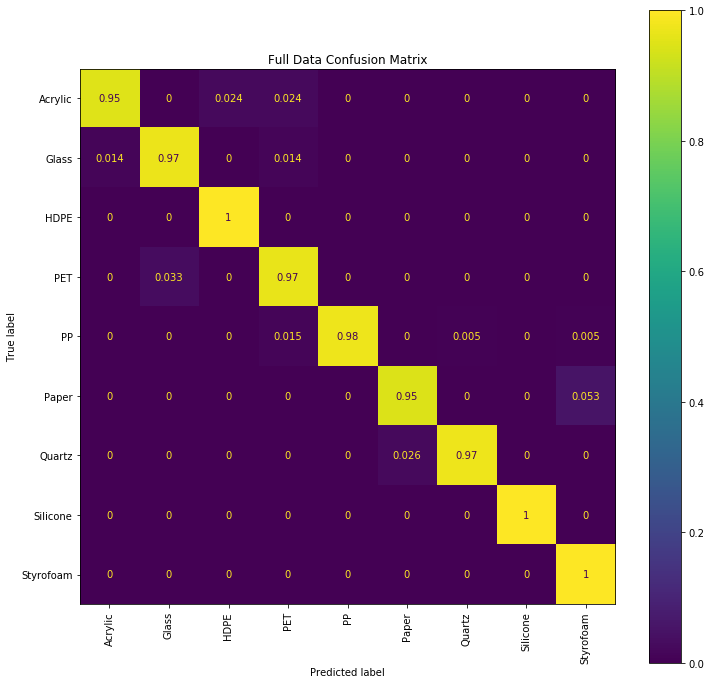

In [28]:
model_master_cross_val('mlp',all_data_container,labels_container,2000,'all_containers','All Contents', trials=10, k_folds=5)

D: 304
K: 9
Using cuda device


Trial::   0%|          | 0/10 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

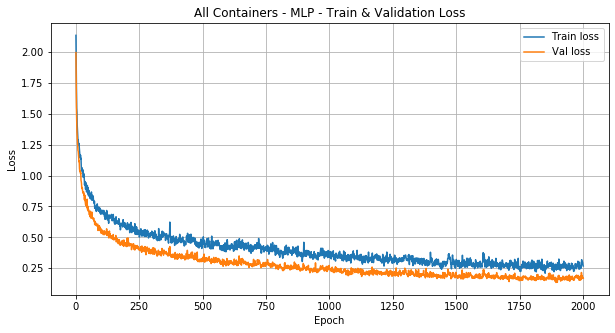

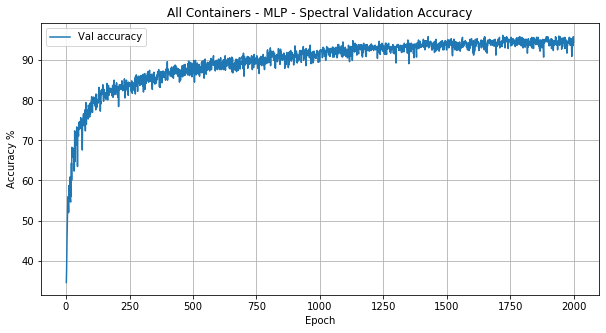

Heldout Test Accuracy: 0.9292762875556946


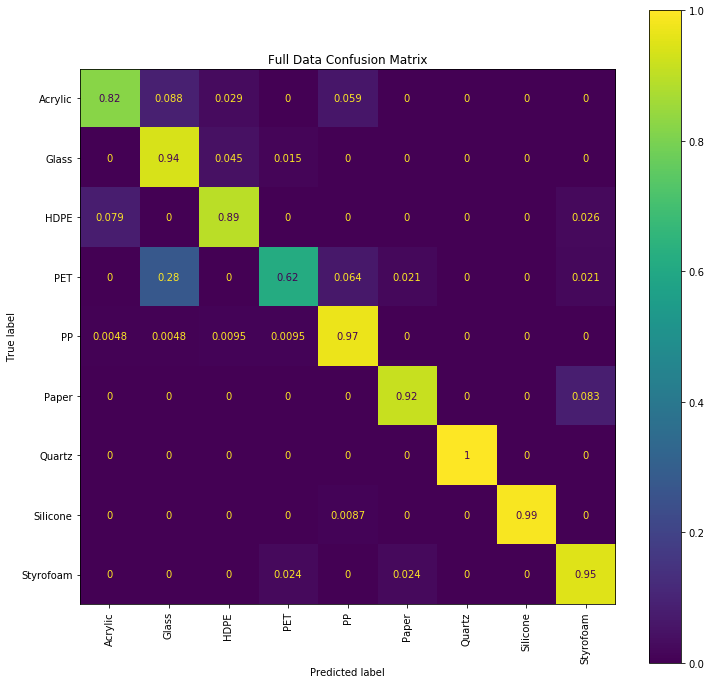

D: 304
K: 9
Using cuda device


Trial::   0%|          | 0/1 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

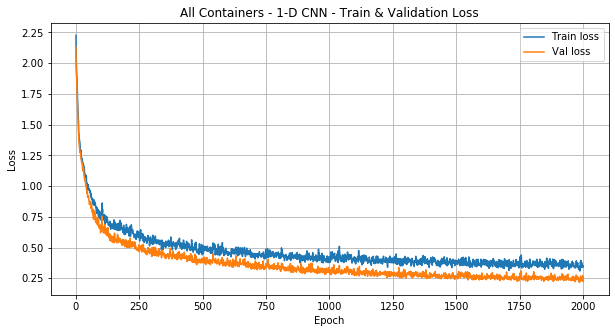

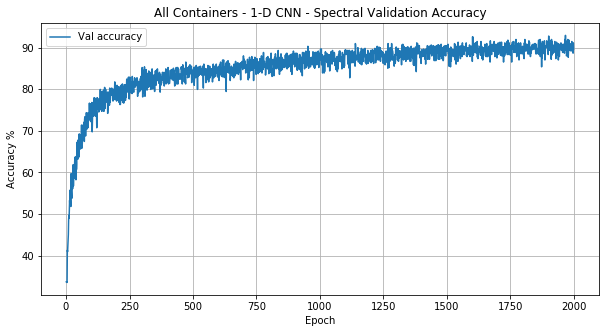

Heldout Test Accuracy: 0.8914473652839661


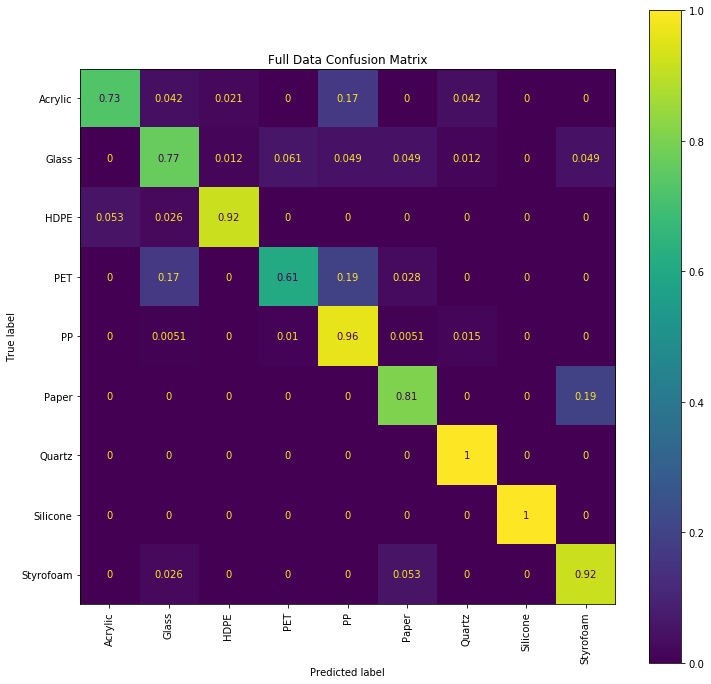

In [29]:
model_master('mlp',all_data_container,labels_container,2000,'all_containers','All Containers - MLP',sigma=0.025,trials=10)
model_master('1DCNN',all_data_container,labels_container,2000,'all_containers','All Containers - 1-D CNN',trials=1)

### Part 2b: Hamamatsu data only

D: 288
K: 9
Using cuda device


Trial::   0%|          | 0/10 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

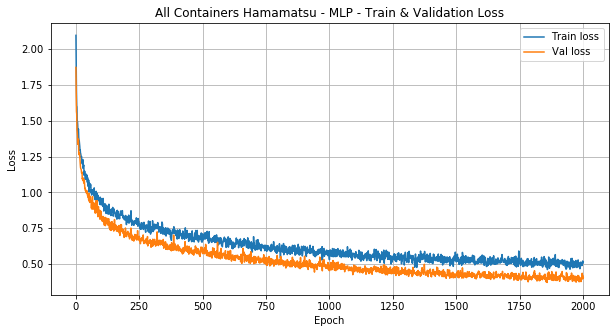

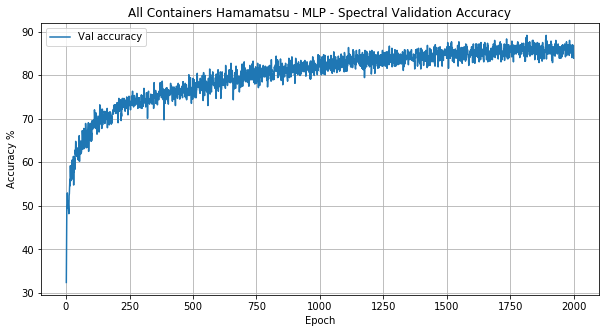

Heldout Test Accuracy: 0.8799341917037964


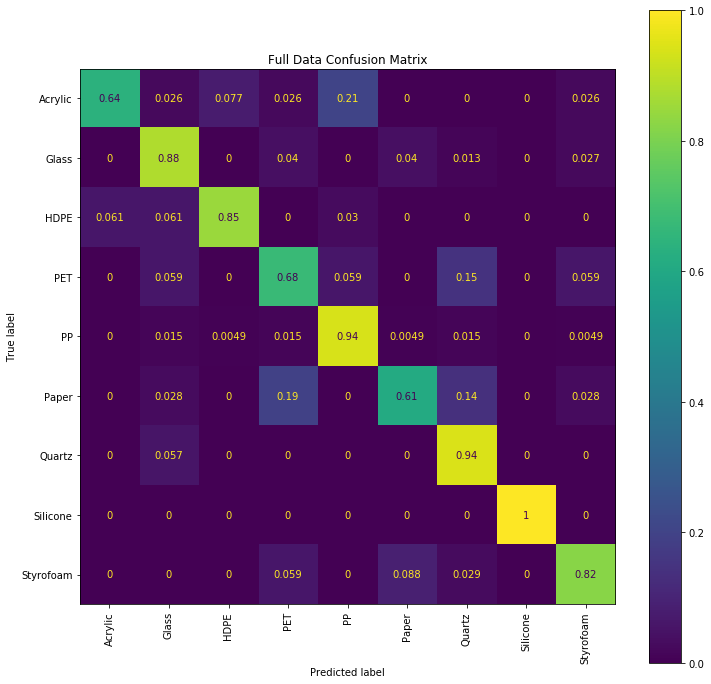

D: 288
K: 9
Using cuda device


Trial::   0%|          | 0/1 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

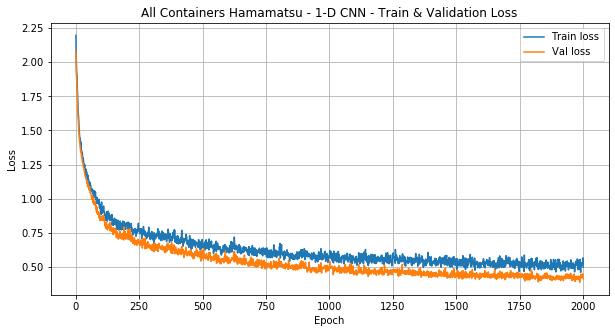

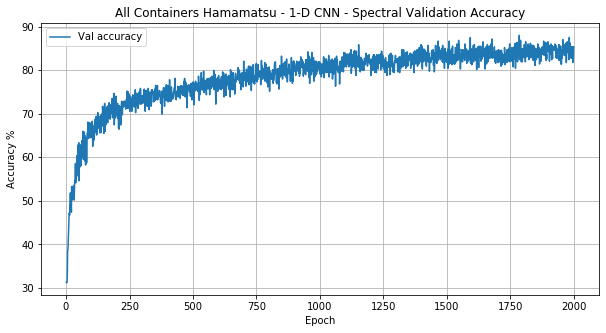

Heldout Test Accuracy: 0.8832237124443054


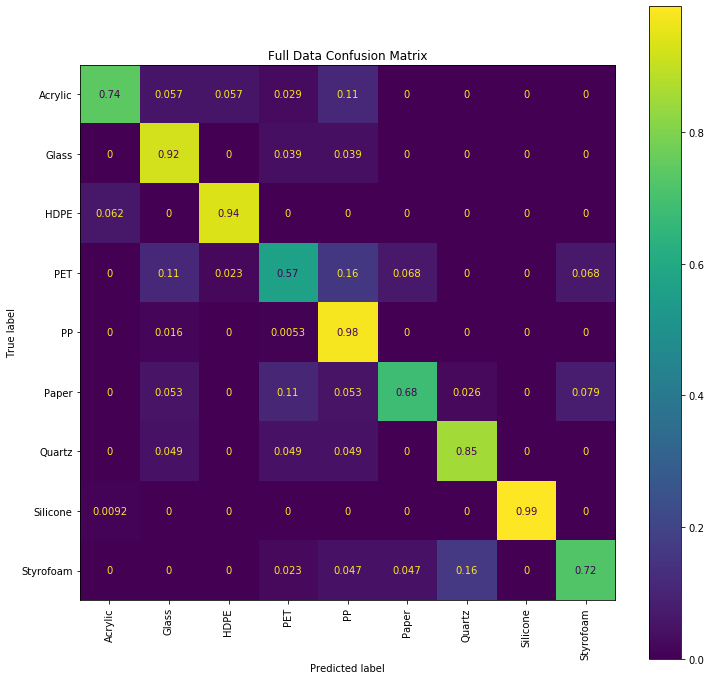

In [30]:
model_master('mlp',all_data_container[:,:-16],labels_container,2000,'all_containers_hamamatsu','All Containers Hamamatsu - MLP',trials=10)
model_master('1DCNN',all_data_container[:,:-16],labels_container,2000,'all_containers_hamatsu','All Containers Hamamatsu - 1-D CNN',trials=1)

### Part 2c: Mantispectra only

D: 16
K: 9
Using cuda device


Trial::   0%|          | 0/10 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

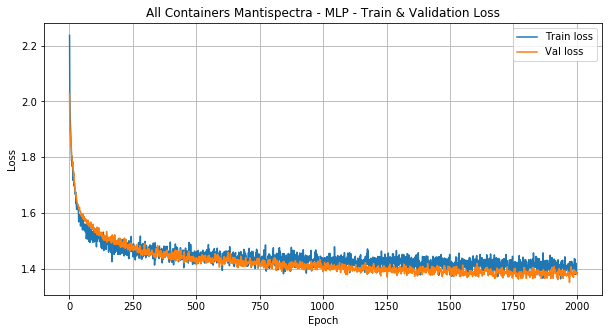

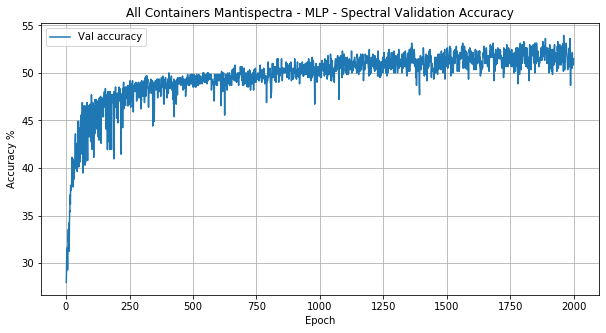

Heldout Test Accuracy: 0.53125


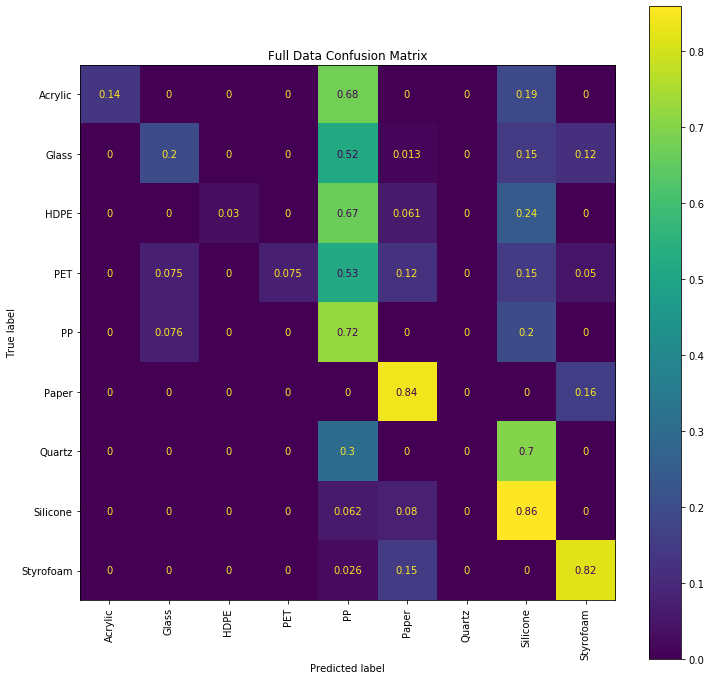

D: 16
K: 9
Using cuda device


Trial::   0%|          | 0/1 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

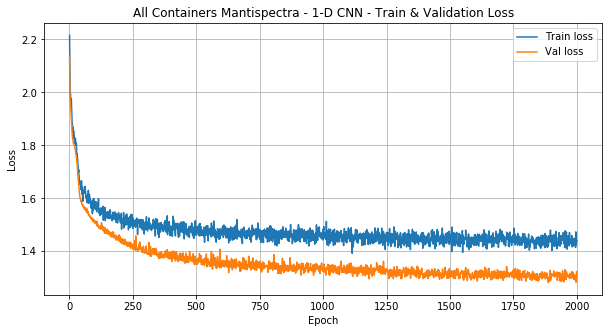

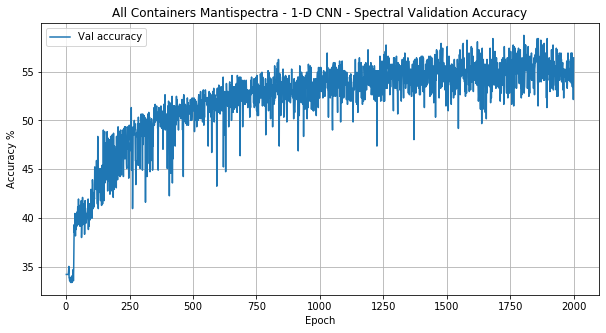

Heldout Test Accuracy: 0.5773026347160339


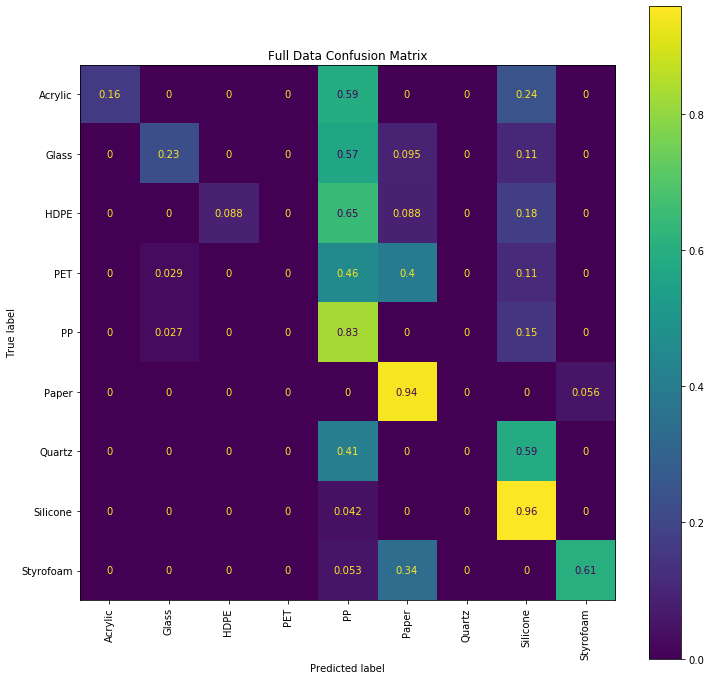

In [31]:
model_master('mlp',all_data_container[:,-16:],labels_container,2000,'all_containers_mantispectra','All Containers Mantispectra - MLP',trials=10)
model_master('1DCNN',all_data_container[:,-16:],labels_container,2000,'all_containers_mantispectra','All Containers Mantispectra - 1-D CNN',trials=1)

### Part 2d: Create Fused Network to Identify Containers

D: 288
K: 9
Using cuda device
D: 16
K: 9
Using cuda device
D: 18
K: 9
Using cuda device


Trial::   0%|          | 0/10 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

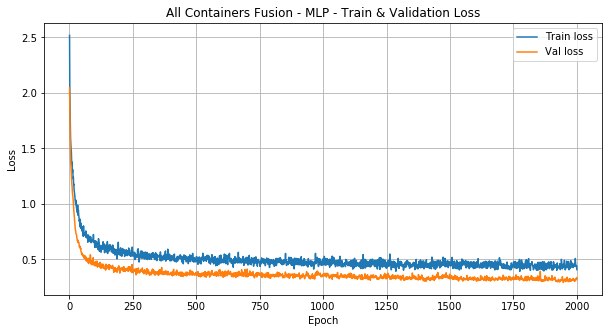

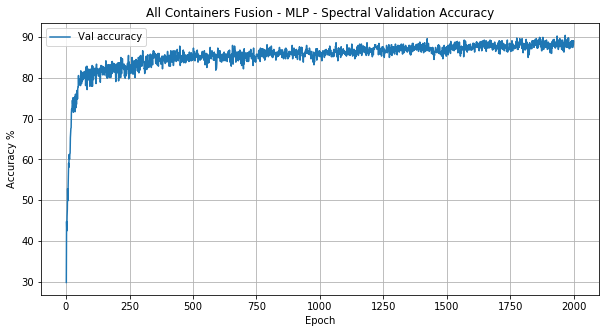

Heldout Test Accuracy: 0.9095394611358643


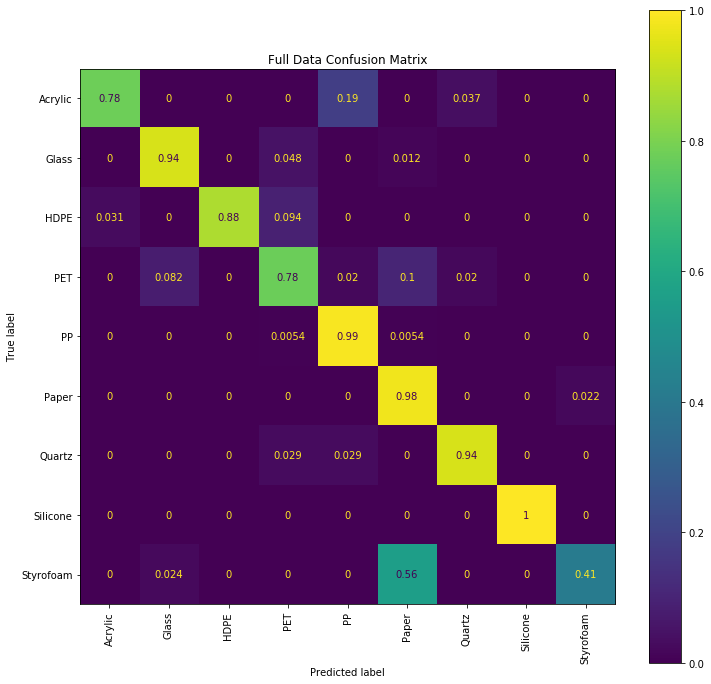

In [32]:
model_hama, device = build_network('mlp', 288, 9)
model_hama.load_state_dict(torch.load(f'./weights/all_containers_hamamatsu__mlp_best.wts', map_location='cpu'))
model_manti, device = build_network('mlp', 16, 9)
model_manti.load_state_dict(torch.load(f'./weights/all_containers_mantispectra__mlp_best.wts', map_location='cpu'))

# Pass all data through model to generate fusion weights
model_hama.eval()
model_manti.eval()
scaler_hama = preprocessing.StandardScaler()
scaler_manti = preprocessing.StandardScaler()
with torch.no_grad():
    pred_hama = scaler_hama.fit_transform(model_hama(torch.Tensor(all_data_container[:,:-16]).double().to(device)).cpu().numpy())
    pred_manti = scaler_manti.fit_transform(model_manti(torch.Tensor(all_data_container[:,-16:]).double().to(device)).cpu().numpy())
    fusion_data = np.hstack((pred_hama,pred_manti))
    
model_master('mlp',fusion_data,labels_container,2000,'all_containers_fusion','All Containers Fusion - MLP', trials=10, hidden_layers=(30,20,18))